## Forest Cover Types (Kaggle)

This notebook discusses my solution for the "Forest Cover Type" problem on Kaggle. It is a *supervised*, multi-category (of forest types) *classification* problem.

The first part of obtaining the solution is just understanding and processing the data before jumping into model building. For that we proceed as follows:
- Making Sense of the Data
    - Baseline prediction before any data processing
    - Understanding the range of the data
    - Detecting and cleaning "null" values
    - Detecting and clearning outliers 

- Feature Analysis
    - Correlating features with target
    - Selecting, engineering features
        - Features with unique values
        - Co-linearity detection

- Separate training, target, validation

Now we turn to model building and performance evaluation.

- Dummy Classifier (Baseline accuracy)
- Compare Several Machine Learning Models
- Perform Hyperparameter Tuning on the Best Model
- Interpret Model Results
- Evaluate the Best Model with Test Data (replying the initiating question)
- Summary & Conclusions

Before discussing the solution we first import the dataset from Kaggle into the Google Drive. One can alo manually upload the data. All the useful libraries are also imported here.

### 0. Importing libraries, the data and utilities

#### 0.1 Imports

In [1]:
# Libraries
from google.colab import drive

import os
from time import time 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# preprocessing functions and evaluation models
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Mount your Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
# Set the configuration (.jason) file to your working directory (here, "Kaggle")
os.environ['KAGGLE_CONFIG_DIR'] = "/gdrive/My Drive/Kaggle"

In [4]:
# changing the working directory

%cd /gdrive/My Drive/Kaggle

/gdrive/My Drive/Kaggle


In [5]:
# Uncomment the lines below to unzip the downloaded files

# !kaggle competitions download -c forest-cover-type-prediction
# !unzip \*.zip  && rm *.zip

#### 0.2 Utils

In [6]:
def one_hot_decode(dataframe, start_loc, end_loc, numeric_column_name):
    ''' 
    This function takes the start and end location of the one-hot-encoded column 
    set and numeric column name to be created as arguments
    (1) transforms one-hot-encoded columns into one column consisting of column 
        names with string data type
    (2) splits string column into the alphabetical and numerical characters
    (3) fetches numerical character and creates numeric column in the given dataframe
    '''

    def split_numbers_chars(row):
        '''
        This function fetches the numerical characters at the end of a string
        and returns alphabetical character and numerical chaarcters respectively
        '''
        head = row.rstrip('0123456789')
        tail = row[len(head):]
        return head, tail
    
    dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1
                                  ).idxmax(axis=1)
    dataframe['Tuple_Column'] = dataframe['String_Column'].apply(
                                                            split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple_Column'].apply(
                                                lambda x: x[1]).astype('int64')

    dataframe.drop(columns=['String_Column','Tuple_Column'], inplace=True)


In [7]:
# function to train a given model, generate predictions, and return accuracy score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    
    return (train_accuracy, valid_accuracy)

In [8]:
# IMP: call 'fit' method of the model before using this.
# Obtains (& plots) top 'top' features with highest importance in the RFC.
def rfc_feature_mdi(model, dataframe, top=20):
    """
    "Feature importances are .. computed as the mean and standard deviation of 
    accumulation of the impurity decrease within each tree" (sklearn)
    """
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]    # reverse sort important features

    print(f"Top {top} Important Features\n")
    for i in range(top): 
        feature_name = dataframe.columns[indices[i]]
        feature_mdi = importances[indices[i]]   # mdi=mean decrease in impurity
        print(f"{i+1}. {feature_name} [{feature_mdi: 0.3} ]")
    print("\n")

    plt.bar(range(top), importances[indices[:top]])
    plt.title("Feature importances using MDI")
    plt.ylabel("Mean decrease in impurity (importance)")
    plt.xticks(range(top), dataframe.columns[indices], rotation=90)

### 1. Making sense of the data


In this section, we are going to the following things.
- "description" of the data [`pd.describe()`]
- Detecting "null" data [`pd.isnull()`]


In [9]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print("Training set =", df_train.shape)
print("Testinng set =", df_test.shape)

print("___The training set___")
df_train.head(10)
# df_train.tail(10)

Training set = (15120, 56)
Testinng set = (565892, 55)
___The training set___


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
5,6,2579,132,6,300,-15,67,230,237,140,6031,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
6,7,2606,45,7,270,5,633,222,225,138,6256,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
7,8,2605,49,4,234,7,573,222,230,144,6228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
8,9,2617,45,9,240,56,666,223,221,133,6244,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
9,10,2612,59,10,247,11,636,228,219,124,6230,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


The features above are:
* Elevation - Elevation in meters 
* Aspect - Aspect in degrees azimuth 
* Slope - Slope in degrees 
* Horizontal_Distance_To_Hydrology - Horizontal Dist to nearest surface water 
* Vertical_Distance_To_Hydrology - Vert. Dist to nearest surface water 
* Horizontal_Distance_To_Roadways - Horizontal Dist to nearest roadway 
* Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice 
* Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice 
* Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
* Horizontal_Distance_To_Fire_Points - Horizontal Dist to nearest wildfire ignition points 
* Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation 
* Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation 
* **Cover_Type** (7 types, integers 1 to 7) - Forest Cover Type designation

In [10]:
# Descriptive statistics of the features.
df_train.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [11]:
# List all the features
features = df_test.columns.values.tolist()
features.remove("Id")

# There are some binary features and some numeral ones
numeral_features = features[:10]
binary_features = features[10:]

# Our target variable is the 'Cover_Type' (how many classes does it have?)
cover_types = sorted(df_train['Cover_Type'].unique())
print("Unique class labels=", cover_types)

Unique class labels= [1, 2, 3, 4, 5, 6, 7]


These are, as stated in the competition, the following forest types:
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz 

In [12]:
# Each cover type has the following value counts.
df_train['Cover_Type'].value_counts()
# Note that they are all the same (that's good) cause the trining algorithsm 
# get to lean about each class equally.

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

In [13]:
# Check if there are any null values
df_train.isnull().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


Great! There're no "null" or "NaN" values. Although this is a great way to catch missing values, if the data collector used a proxy (e.g. '0') for the missing value then we need to catch it in other ways (mostly using common sense). E.g., below we can see, 88 entries have 0 for Hillshade_3pm whereas the corresponding Hillshade_9am or Hillshade_Noon are all pretty "bright". Rainy days aside, this number seems a bit too high. Probably some of them are proxy for the missing values. We will discuss this later.

In [14]:
df_train[df_train['Hillshade_3pm'] ==0]

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
1375,1376,2806,76,39,234,119,255,235,141,0,1371,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1411,1412,2773,80,48,124,112,134,226,107,0,1298,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
1416,1417,2779,78,47,134,118,150,227,111,0,1318,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
1419,1420,2786,76,46,150,132,162,226,113,0,1338,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
1423,1424,2743,76,49,134,81,150,222,103,0,1337,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14068,14069,3417,86,46,342,186,2405,234,120,0,607,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7
14120,14121,3323,75,46,153,123,2754,225,114,0,400,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7
14366,14367,3336,93,37,242,-26,4094,248,157,0,3601,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7
14672,14673,3398,108,32,270,79,2334,254,184,0,918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7


In [15]:
# Notice that the 'Soil_Type' and the 'Wilderness_Area' are one-hot-encoded 
# features. There are 40 soil types and 4 wilderness areas. You can check they 
# are binary data

is_binary_columns = [column for column in df_train.columns if 
                     ("Wilderness" in column) | ("Soil" in column)]
pd.unique(df_train[is_binary_columns].values.ravel())

array([1, 0])

In [16]:
# Notice something interesting
print(df_train['Soil_Type7'].unique())
print(df_train['Soil_Type15'].unique())
# These two soil types are never present! (we'll get back to it later).

[0]
[0]


In [17]:
# Before moving forward lets just remove the 'Id' column as that is not a real 
# information but might screw our training.
df_train = df_train.drop(['Id'], axis=1)

*Section Summary & Action Plan*
* 4 different wilderness areas, 40 different soil types are already one-hot-encoded.
* There are 7 unique (equally distributed) cover types.
* There are no missing values but Hillside_3pm contains spurious zeros (must be regressed).
* Soil_Type 7 and 15 have no predictive function (must be removed)

---

### 2. Baseline Test
 So far we have done nothing to the raw data (except try to understand it). Let's just see how accurate a simple Random Forest classifier would be this "unpolished" dataset. Any data processing we do must improve from the baseline numbers, otherwise the processing is baseless.

In [18]:
X_features = df_train.drop(['Cover_Type'], axis=1)
y_labels = df_train['Cover_Type'].values

X_train, X_valid, y_train, y_valid = train_test_split(
                                        X_features, 
                                        y_labels, 
                                        test_size=0.2, 
                                        random_state=42)

print('Training Data Shape:', X_train.shape)
print('Validation Data Shape:', X_valid.shape)

Training Data Shape: (12096, 54)
Validation Data Shape: (3024, 54)


In [19]:
# The baseline classifier-we try a few basic methods and compare their performances.

# base_clf = SVC()  # Train: 64%, Valid: 63%
# base_clf = KNeighborsClassifier()   # Train: 88%, Valid: 81%
# base_clf = XGBClassifier()  # Train: 77%, Valid: 75%
base_clf = RandomForestClassifier() # Train: 100%, Valid: 87%

score_train, score_valid = fit_evaluate_model(base_clf, 
                            X_train, y_train, X_valid, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 100.0%
Validation accuracy = 86.54%


**Observation** 
- The plain vanila RFC already seems to be doing a great job compared to other methods. 
- Interestingly, a simple RFC is already proving to be 100% accurate on the training data! However, clearly, there is some degree of over-fitting as well. We will have to address this. We don't have much control over the data size so maybe our best bet is feature engineering. But before that lets see exactly which cover types are pulling down the validation accuracy (with the help of the confusion matrix).

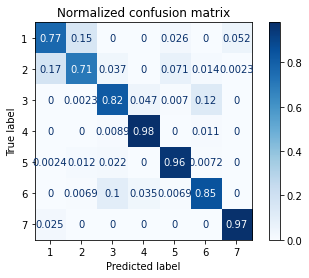

In [20]:
# Plot the confusion matrix
disp = plot_confusion_matrix(estimator=base_clf, 
                             X=X_valid, y_true=y_valid,
                             display_labels=cover_types,
                             cmap=plt.cm.Blues,
                             normalize='true')

disp.ax_.set_title("Normalized confusion matrix")

plt.show()

**Observation**: 
* Types 4 & 7 are most easily predictable. 
* Cover types 1-2 are being miss-labeled the most. In the EDA section we will try to understand the features that are most predictive of types 1-2 and try to engineering something with them.

Top 15 Important Features

1. Elevation [ 0.219 ]
2. Horizontal_Distance_To_Roadways [ 0.0918 ]
3. Horizontal_Distance_To_Fire_Points [ 0.0714 ]
4. Horizontal_Distance_To_Hydrology [ 0.0637 ]
5. Hillshade_9am [ 0.0528 ]
6. Vertical_Distance_To_Hydrology [ 0.0519 ]
7. Aspect [ 0.049 ]
8. Hillshade_3pm [ 0.0467 ]
9. Hillshade_Noon [ 0.0452 ]
10. Wilderness_Area4 [ 0.0439 ]
11. Slope [ 0.0372 ]
12. Soil_Type10 [ 0.0242 ]
13. Soil_Type38 [ 0.0212 ]
14. Wilderness_Area1 [ 0.0209 ]
15. Soil_Type3 [ 0.0184 ]




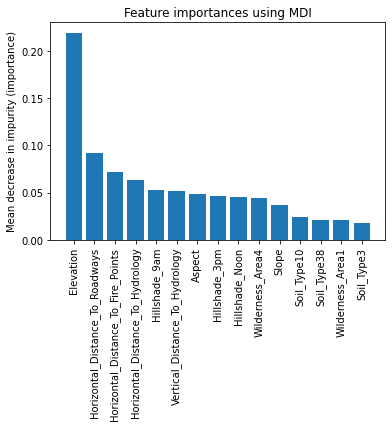

In [21]:
# So what features are the most important ones in the above prediction?
rfc_feature_mdi(model=base_clf, dataframe=df_train, top=15)

**Observation**: Clearly, 'Elevation' is a really important feature so engineering more features off of it might help. All the distances seem to be the second most important features so we try to play with them as well. 

*Section Summary & Action Plan*
* A RFC works the best (validation accuracy=87%) on unprocessed data (tweak this model).
* There is high degree of variance (training accuracy=100%). (kill features)
* [4,7,5,6,3,1,2] is in order of increasing difficulty to predict the cover type. (find features)
* Elevation is the most important feature, followed by the distance. (feature engineer)

---

### 3. Exploratory Data Analysis (EDA)

#### 3.1 Outlier Detection

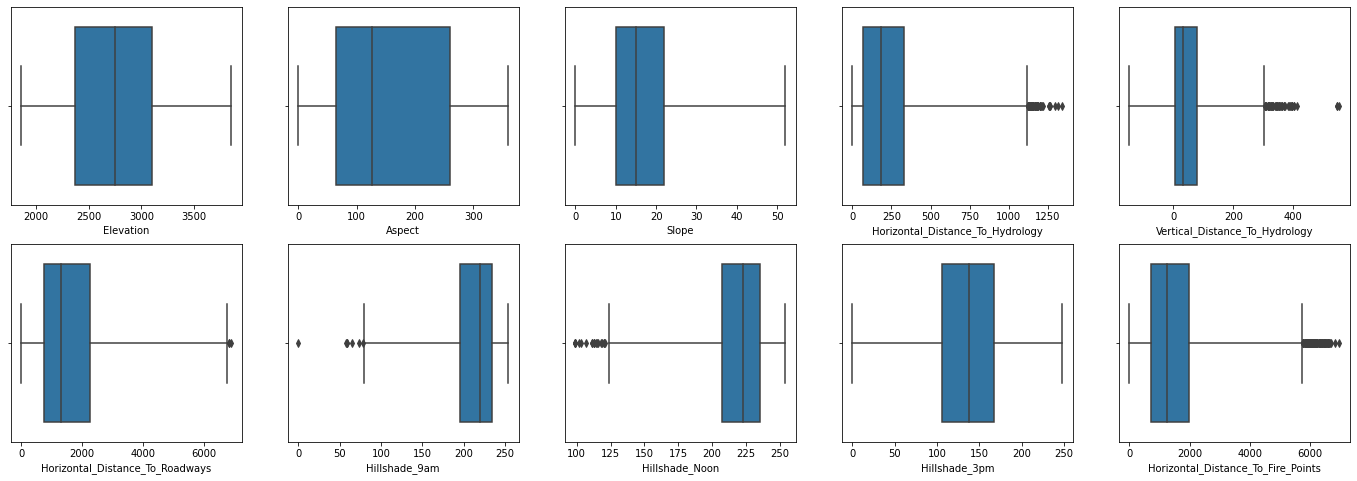

In [22]:
# First plot the box-whisker plot to visualize the outliers

rows, cols = 2, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 8))
start = 0
for j in range(rows):
    for i in range(cols):
        if start == len(numeral_features):
            break
        sns.boxplot(x=df_train[numeral_features[start]],
                    whis=3, ax=ax[j, i])
        # A large 'whis' value is used (default=1.5). Otherwise, there are way 
        # too many data-points outside the box.
        start += 1


In [23]:
# Now removing the outlier using Tukey's fences
# [Q1 - whis*iqr, Q3 + whis*iqr]  (iqr=Q3-Q1)

outlier_index = dict()

print("___Outlier Count per Feature___")

for feature in numeral_features:
    
    q3 = np.percentile(df_train[feature], 75)
    q1 = np.percentile(df_train[feature], 25)
    
    iqr = q3 - q1
    whis = 3
    
    l_bound = q1 - iqr * whis
    u_bound = q3 + iqr * whis
    
    # List of indices where the attribute value lies outside the bounds
    feature_outliers = df_train[(df_train[feature] < l_bound) | 
                                (df_train[feature] > u_bound)].index
    
    print(len(feature_outliers), ':', feature)

    outlier_index[feature] = feature_outliers
    # The outliers (row indices) are saved in a dictionary of features

___Outlier Count per Feature___
0 : Elevation
0 : Aspect
0 : Slope
53 : Horizontal_Distance_To_Hydrology
49 : Vertical_Distance_To_Hydrology
3 : Horizontal_Distance_To_Roadways
7 : Hillshade_9am
20 : Hillshade_Noon
0 : Hillshade_3pm
132 : Horizontal_Distance_To_Fire_Points


**Observation**: Hillshades are not truely outliers beacause they are just RGB values (0 through 255). Therefore, we ignore the correspong outliers obtained above. The other important features with outliers are the distances. Looking at the range of these data, since fire point distance has the widest range we will definitely take its outlier seriously. The second important outlier would be rodways distance. Being so few outliers, we ignore them. The remaining features do not seem to have a sizable range (compared to the fire point distances) to be worth removing (at the cost of loosing about 100 data points). 

LEFT ⟶ Removed  132 data points (rows) ⟶ RIGHT 



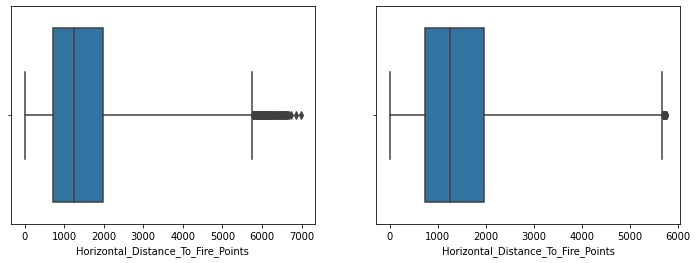

In [24]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

# Box plot before removing the outliers
sns.boxplot(x=df_train['Horizontal_Distance_To_Fire_Points'], whis=3, ax=ax[0])

df_train_updated = df_train.drop(outlier_index['Horizontal_Distance_To_Fire_Points'])

# Box plot after removing the outliers
sns.boxplot(x=df_train_updated['Horizontal_Distance_To_Fire_Points'], whis=3, ax=ax[1])
print("LEFT \u27F6 Removed ", df_train.shape[0] - df_train_updated.shape[0], "data points (rows) \u27F6 RIGHT \n")

We will study each category of features in more detail.

- Correlating features with Target

- Statistical distribution of features
    - Categorical data using box plots
    - Numeral data using hist plots

#### 3.2 Categorical Featues

##### 3.2.1 Wilderness Type

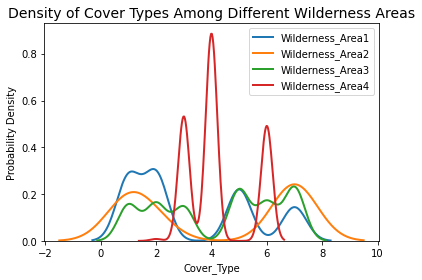

In [25]:
# Create one column as Wilderness_Area_Type and represent it as categorical data
wild_1 = df_train_updated.columns.get_loc('Wilderness_Area1')
wild_4 = df_train_updated.columns.get_loc('Wilderness_Area4') + 1

df_train_updated['Wilderness_Area_Type'] = (df_train_updated.iloc[:, 
                                                wild_1:wild_4] == 1).idxmax(1)

# list of wilderness areas
wilderness_areas = sorted(df_train_updated['Wilderness_Area_Type'].value_counts().index.tolist())

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = df_train_updated[df_train_updated['Wilderness_Area_Type'] == area]
    sns.kdeplot(subset["Cover_Type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Probability Density")
plt.xlabel("Cover_Type")
plt.legend()
plt.title("Density of Cover Types Among Different Wilderness Areas", size=14)
plt.show()

**Observation**: Area 4 has Type 3,4,6 forests the most. Area 3 has almost all types of forests except Type 4. Area 2 has mostly Type 1 and 7. Area 1 has 1, 5, 7 as the most prominent type. An important takeaway is that types 1, 2 & 7 all belong to area 1, 2, 3 with almost equal probabilities. So Wilderness_Area is not a strong predictor for imporving our predictibility for area 1 & 2.

##### 3.2.2 Soil Type

In [26]:
# Lets first remove the type 7 & 15 as concluded before

try:
    df_train_updated = df_train_updated.drop(['Soil_Type7', 'Soil_Type15'], axis=1)
except KeyError:
    pass
    
# The removal has been performed and the number of colums must be fewer now.
df_train_updated.shape

(14988, 54)

In [27]:
# We also create a new column which removes the one-hot-encoding.
soil_1 = df_train_updated.columns.get_loc('Soil_Type1')
soil_40 = df_train_updated.columns.get_loc('Soil_Type40') + 1

one_hot_decode(df_train_updated, soil_1, soil_40, "Soil_Type")

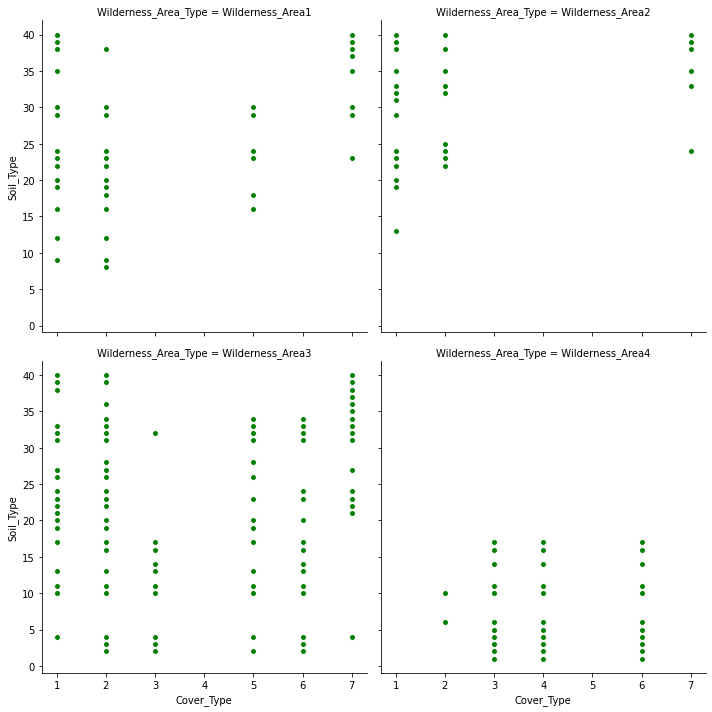

In [28]:
# plot relationship of soil type and cover type among different wilderness areas
g = sns.FacetGrid(df_train_updated, col="Wilderness_Area_Type", 
                  col_wrap=2, height=5, col_order=wilderness_areas)

g = g.map(plt.scatter,"Cover_Type", "Soil_Type", edgecolor="w", color="g")

**Observation**: One thing we learn from this plot is, wilderness area aside, type 5,7 are very selective of the soil type. On the otherhand, type 1,2 seem to be doing fairly well in almost all kinds of soil types. 

#### 3.3 Numeral Features

##### 3.3.1 Distributions

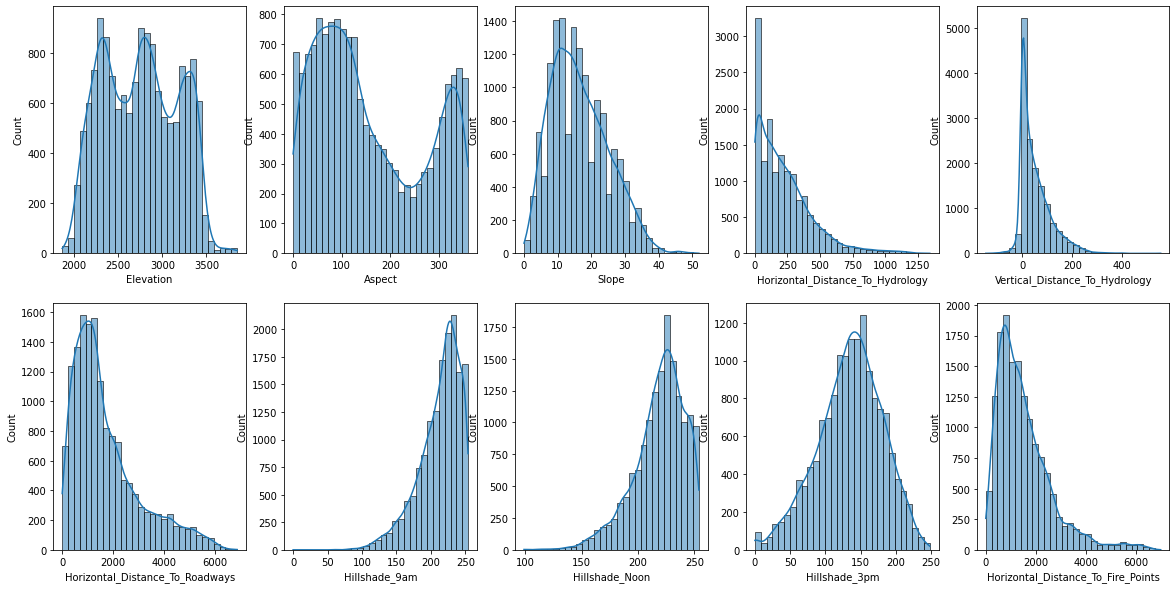

In [29]:
# First plot the distribution functions of each consitnuous feature
rows, cols = 2, 5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10))
start = 0
for i in range(rows):
    for j in range(cols):
        if start == len(numeral_features):
            break
        sns.histplot(df_train[numeral_features[start]], 
                     kde=True, bins=30, ax=ax[i,j])
        start += 1

**Observations**: 
- Hillshade 9am and Noon have left-skewed distributions.
- Horizontal_Distance_To_Firepoints, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Hydrology have right-skewed distributions.
- Elevation somewhat resembles a uniform distribution (or a tri-modal one?).
- Slope, Vertical_Distance_To_Hydrology, Hillshade_3pm show a more symmetric distribution.
- Notice the tall bar at 0 tick of Hillshade_3pm (recall missing value discussion earlier)


##### 3.3.2 Colinearity

In [30]:
# make a list of numeric features and create a dataframe with them
all_features = numeral_features + wilderness_areas + ["Soil_Type"] + ["Cover_Type"]
trans_df = df_train_updated[all_features]
trans_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type,Cover_Type
11,2886,151,11,371,26,5253,234,240,136,4051,1,0,0,0,30,2
14,2503,157,4,67,4,674,224,240,151,5600,1,0,0,0,18,5
15,2495,51,7,42,2,752,224,225,137,5576,1,0,0,0,16,5
17,2517,72,7,85,6,595,228,227,133,5607,1,0,0,0,18,5
18,2504,0,4,95,5,691,214,232,156,5572,1,0,0,0,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2607,243,23,258,7,660,170,251,214,1282,0,0,1,0,4,3
15116,2603,121,19,633,195,618,249,221,91,1325,0,0,1,0,4,3
15117,2492,134,25,365,117,335,250,220,83,1187,0,0,1,0,4,3
15118,2487,167,28,218,101,242,229,237,119,932,0,0,1,0,4,3


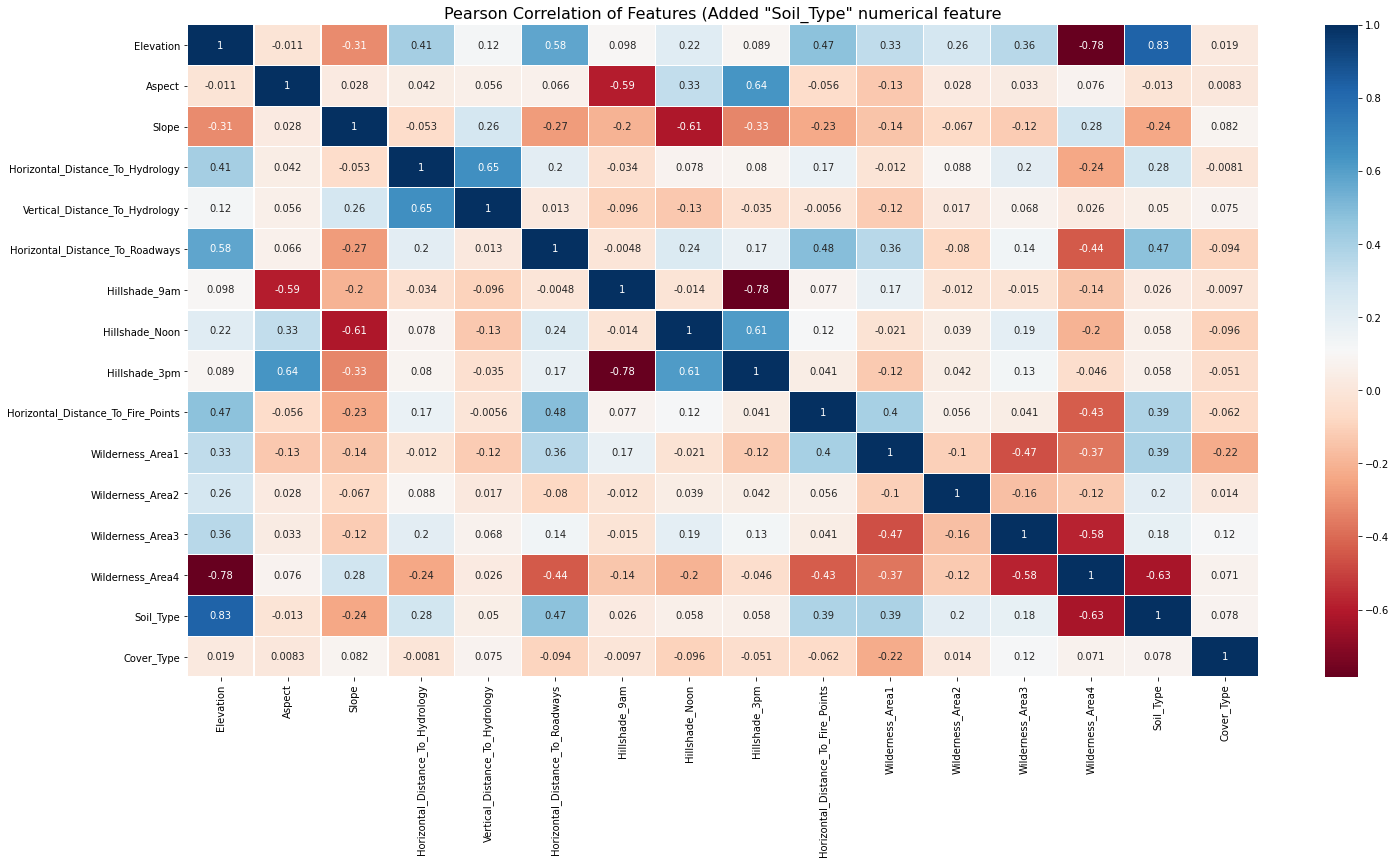

In [31]:
# pearson coefficients with numeric soil type column
correlations = pd.DataFrame(trans_df.corr())

# plot the heatmap
colormap = plt.cm.RdBu
fig, ax = plt.subplots(figsize=(24,12)) 
sns.heatmap(correlations,linewidths=0.1, 
            square=False, cmap=colormap, linecolor='white', annot=True)
plt.title('Pearson Correlation of Features (Added "Soil_Type" numerical feature', size=16)
plt.show()

**Observation** There are clearly some strong colinearities and we might want to address them. First we visualize what exactly their correlation looks like. The following correlations are analyzed:
1. Hillshade_3pm -- Hillshade_9am (r = -78%)
2. Hillshade_3pm -- Hillshade_Noon (r = 61%)
3. Vertical_ -- Horizontal_Distance_To_Hydrology (r = 65%)
Let's have a better look at them


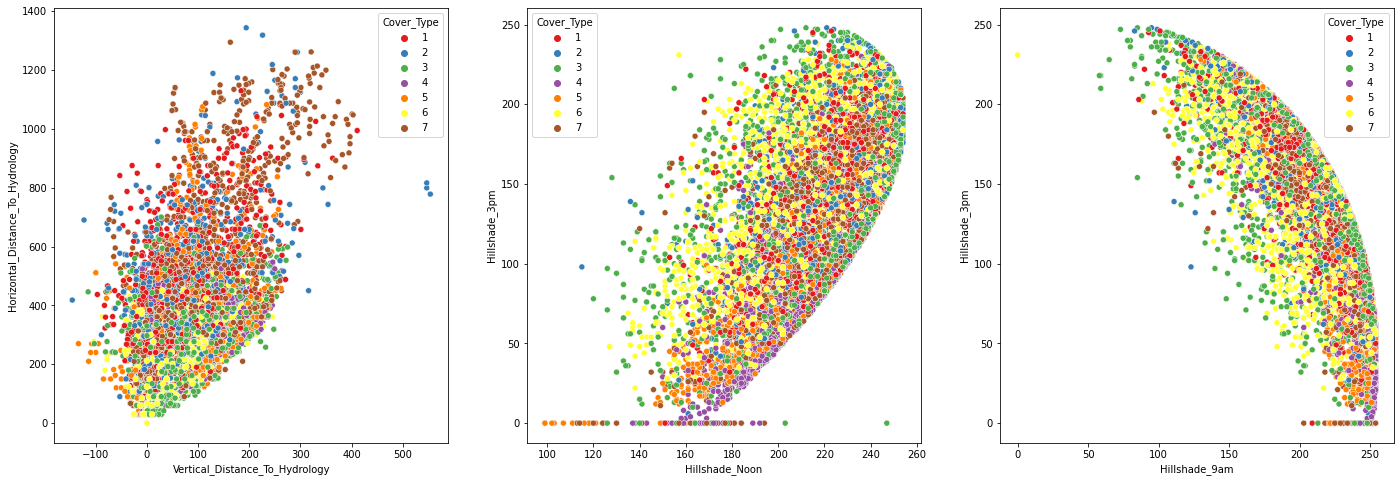

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8)) 

sns.scatterplot(x="Vertical_Distance_To_Hydrology", y="Horizontal_Distance_To_Hydrology", 
                hue="Cover_Type", data=df_train_updated, 
                legend="full", hue_norm=(0,8), palette="Set1", ax=ax[0])

sns.scatterplot(x="Hillshade_Noon", y="Hillshade_3pm", 
                hue="Cover_Type", data=df_train_updated, 
                legend="full", hue_norm=(0,8), palette="Set1", ax=ax[1])

sns.scatterplot(x="Hillshade_9am", y="Hillshade_3pm", 
                hue="Cover_Type", data=df_train_updated, 
                legend="full", hue_norm=(0,8), palette="Set1", ax=ax[2])


The proxy zeros show up again as the horizontal line in the above figures. We clearly need to remove them. To do so we check hillshade at 9am and noon (when 3pm has zeros) and from there we regress 3pm data.

##### 3.3.3. Hillshade 3pm [work from here]


[this git](https://shankarmsy.github.io/posts/forest-cover-types.html)

[check against](https://github.com/cereniyim/Tree-Classification-ML-Model/blob/master/fantastic-trees-where-to-find-how-to-detect-them.ipynb)

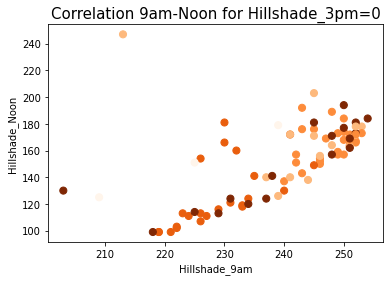

In [33]:
smaller_frame=trans_df[trans_df['Hillshade_3pm'] ==0]

plt.scatter(smaller_frame.Hillshade_9am,smaller_frame.Hillshade_Noon, 
            c=smaller_frame.Cover_Type, s=50, cmap=plt.cm.Oranges) 
plt.title('Correlation 9am-Noon for Hillshade_3pm=0', fontsize=15) 
plt.xlabel('Hillshade_9am') 
plt.ylabel('Hillshade_Noon') 
plt.show()

### 4. Feature Engineering

In [34]:
# Use Euclidean distance
euclid = (trans_df['Horizontal_Distance_To_Hydrology']**2 + 
          trans_df['Vertical_Distance_To_Hydrology']**2)**0.5
trans_df.loc[:, 'Euclidean_Distance_To_Hydrology'] = euclid
trans_df.loc[:, 'Sqrt_Euclidean_Distance_To_Hydrology'] = euclid**0.5

# effective elevation of a tree
eff_elev = (trans_df['Elevation'] + trans_df['Vertical_Distance_To_Hydrology'])/2
trans_df.loc[:, 'Mean_Elevation_Vertical_Distance_Hydrology'] = eff_elev
trans_df.loc[:, 'Sqrt_Mean_Elevation_Vertical_Distance_Hydrology'] = eff_elev**0.5

#
hydro_fire = (trans_df['Horizontal_Distance_To_Hydrology'] + 
     trans_df['Horizontal_Distance_To_Fire_Points'])/2
trans_df.loc[:, 'Mean_Distance_Hydrology_Firepoints'] = hydro_fire
trans_df.loc[:, 'Sqrt_Mean_Distance_Hydrology_Firepoints'] = hydro_fire**0.5

#
hydro_road = (trans_df['Horizontal_Distance_To_Hydrology'] + 
                trans_df['Horizontal_Distance_To_Roadways'])/2
trans_df['Mean_Distance_Hydrology_Roadways'] = hydro_road
trans_df['Sqrt_Mean_Distance_Hydrology_Roadways'] = hydro_road**0.5

# 
fire_road = (trans_df['Horizontal_Distance_To_Fire_Points'] + 
                trans_df['Horizontal_Distance_To_Roadways'])/2
trans_df.loc[:, 'Mean_Distance_Firepoints_Roadways'] = fire_road
trans_df.loc[:, 'Sqrt_Mean_Distance_Firepoints_Roadways'] = fire_road**0.5

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [35]:
trans_df.shape

(14988, 26)

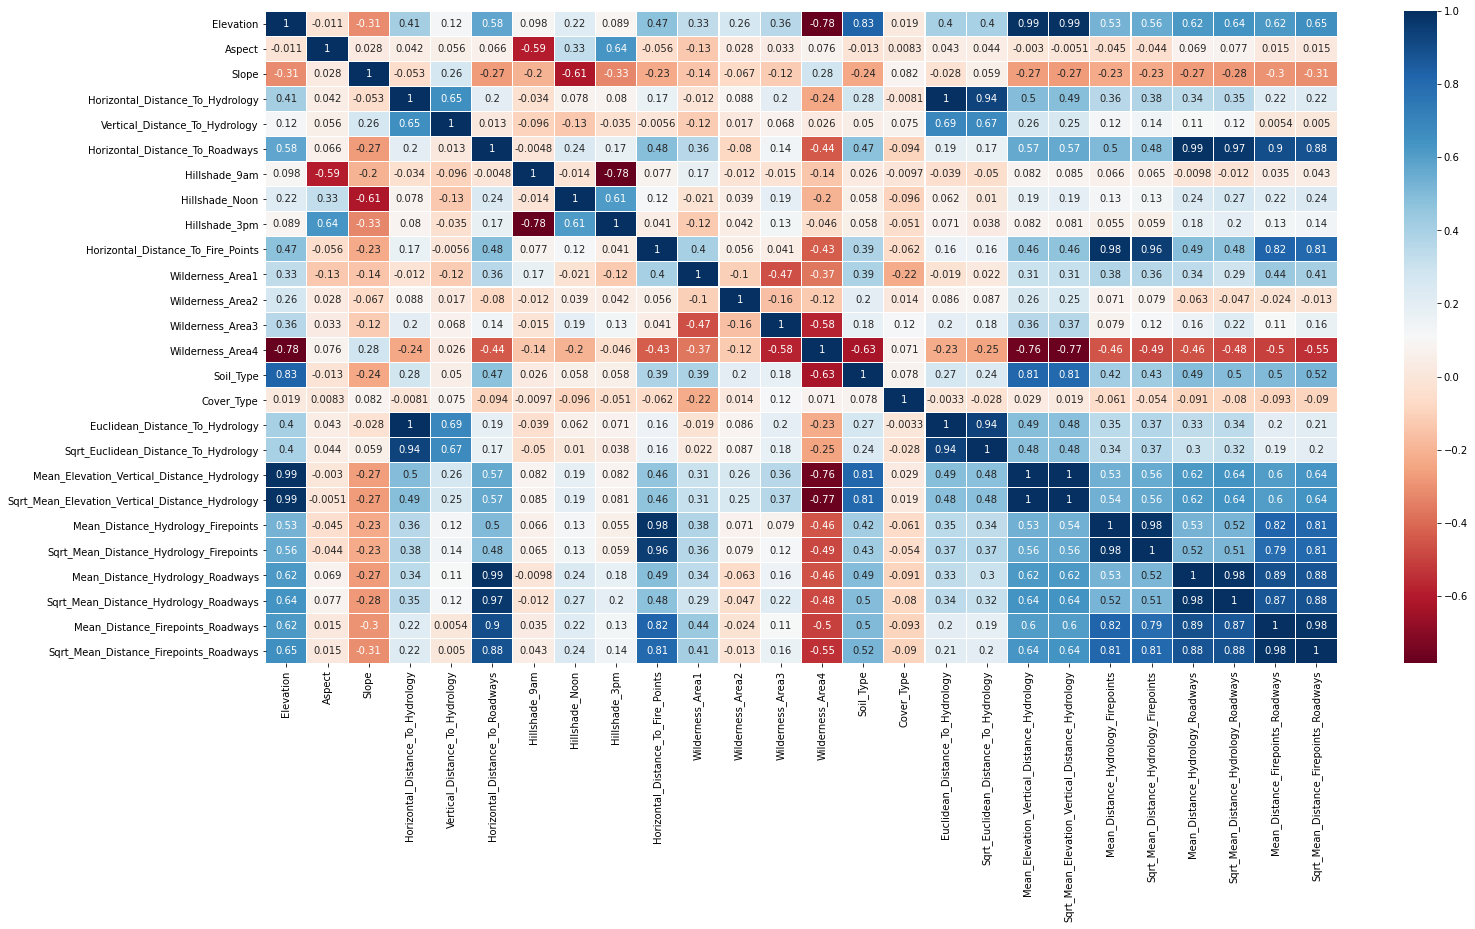

In [36]:
# Let's take a look at the new correlation matrix
correlations = pd.DataFrame(trans_df.corr())

# plot the heatmap
colormap = plt.cm.RdBu
fig, ax = plt.subplots(figsize=(24,12)) 
sns.heatmap(correlations,linewidths=0.1, 
            square=False, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [37]:
# You can see how each feature correlate with the target variable (Cover_Type).
# For clarity, let's print these values in an orderly fashion so that we can
# eliminate the features with the least correlations.
# create a df after droppping all the Soil_TypeX.

correlations_transformed = pd.DataFrame(trans_df.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["Cover_Type"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with Cover_Type"]
correlations_transformed = (correlations_transformed[correlations_transformed["Feature"] != "Cover_Type"]
                .sort_values(by="Correlation with Cover_Type", ascending=True, key=abs))
display(correlations_transformed)

,Feature,Correlation with Cover_Type
16,Euclidean_Distance_To_Hydrology,-0.003281
3,Horizontal_Distance_To_Hydrology,-0.008078
1,Aspect,0.008252
6,Hillshade_9am,-0.009710
11,Wilderness_Area2,0.013653
19,Sqrt_Mean_Elevation_Vertical_Distance_Hydrology,0.019139
0,Elevation,0.019360
17,Sqrt_Euclidean_Distance_To_Hydrology,-0.027739
18,Mean_Elevation_Vertical_Distance_Hydrology,0.029451
8,Hillshade_3pm,-0.051264


In [38]:
# We are drawing a cut-off of corr~0.03. Features with lower correlation 
# are dropped from the final dataframe. This number is arbitrary, sort of 
# a hyperparameter. Note, keeping a large number of features will introduce
# high varaince. So play with this cut-off 

final_df = trans_df.drop([
                          'Euclidean_Distance_To_Hydrology', 
                          'Horizontal_Distance_To_Hydrology',
                          'Aspect',
                          'Hillshade_9am',
                          'Sqrt_Mean_Elevation_Vertical_Distance_Hydrology',
                          'Mean_Elevation_Vertical_Distance_Hydrology',
                          'Sqrt_Mean_Distance_Hydrology_Firepoints',
                          'Sqrt_Mean_Distance_Hydrology_Roadways',
                          'Sqrt_Mean_Distance_Firepoints_Roadways'
                          ], axis=1)

final_df

,Elevation,Slope,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type,Cover_Type,Sqrt_Euclidean_Distance_To_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways
11,2886,11,26,5253,240,136,4051,1,0,0,0,30,2,19.284967,2211.0,2812.0,4652.0
14,2503,4,4,674,240,151,5600,1,0,0,0,18,5,8.192637,2833.5,370.5,3137.0
15,2495,7,2,752,225,137,5576,1,0,0,0,16,5,6.484411,2809.0,397.0,3164.0
17,2517,7,6,595,227,133,5607,1,0,0,0,18,5,9.231008,2846.0,340.0,3101.0
18,2504,4,5,691,232,156,5572,1,0,0,0,18,5,9.753537,2833.5,393.0,3131.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2607,23,7,660,251,214,1282,0,0,1,0,4,3,16.065334,770.0,459.0,971.0
15116,2603,19,195,618,221,91,1325,0,0,1,0,4,3,25.736256,979.0,625.5,971.5
15117,2492,25,117,335,220,83,1187,0,0,1,0,4,3,19.577886,776.0,350.0,761.0
15118,2487,28,101,242,237,119,932,0,0,1,0,4,3,15.500331,575.0,230.0,587.0


### 5. Split & Standardize

In [39]:
# We now separate the features and the targets from the dataframe
trees_training = final_df.drop(['Cover_Type'], axis=1)
labels_training = final_df["Cover_Type"].values

In [40]:
# Separate the data into training and validation sets

seed = 12
X_train, X_valid, y_train, y_valid = train_test_split(trees_training, labels_training, 
                                                      test_size=0.2, random_state=seed)

print('Training Data Shape:', X_train.shape)
print('Validation Data Shape:', X_valid.shape)

Training Data Shape: (11990, 16)
Validation Data Shape: (2998, 16)


In [41]:
# create scaler
sc = StandardScaler()

# apply standardization and transform the training set
X_train_scaled = sc.fit_transform(X_train, y_train)

# transform validation set
X_valid_scaled = sc.transform(X_valid)

### 4. Model Testing


#### 4.1 Models out-of-the-box
We first test a few well known classifiers to see how they fare with each other, and most importantly with the baseline predictor. 

##### 4.1.0 Dummy Predictor

In [42]:
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=1)

# train the model
dummy.fit(X_train_scaled, y_train)

# Get accuracy score
baseline_accuracy = dummy.score(X_valid_scaled, y_valid)
print("Dummy algorithm classified {:0.2f} of the of the trees correctl!".format(baseline_accuracy))

Dummy algorithm classified 0.14 of the of the trees correctl!


##### 4.1.1 SVC

In [43]:
clf = SVC()
score_train, score_valid = fit_evaluate_model(clf, 
                            X_train_scaled, y_train, X_valid_scaled, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 78.76%
Validation accuracy = 77.32%


##### 4.1.2 K-NN Classifier

In [44]:
clf = KNeighborsClassifier()
score_train, score_valid = fit_evaluate_model(clf, 
                            X_train_scaled, y_train, X_valid_scaled, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 87.18%
Validation accuracy = 79.95%


##### 4.1.3 XGBoost

In [45]:
clf = XGBClassifier()
score_train, score_valid = fit_evaluate_model(clf, 
                            X_train_scaled, y_train, X_valid_scaled, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 78.7%
Validation accuracy = 77.12%


##### 4.1.4 Random Forest

In [46]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy")
score_train, score_valid = fit_evaluate_model(clf, 
                            X_train_scaled, y_train, X_valid_scaled, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 100.0%
Validation accuracy = 87.63%


Random Forest seems to perform the best. Clearly there is a lot of variance at this configuration though. Next we perform hyper-parameter optimization to reduce variance. Since it's Random Forest, we will use a meta estimator for this (ExtraTreesClassifier) that fits a number of randomized decision trees on various sub-samples of the dataset. We also usek-fold cross validation.

#### 4.2 Hyper-parameter Optimization

In [47]:
# We are going to search over the hparam space given by the following vectors.

# The number of trees in the forest algorithm (default=100).
n_estimators = [50, 100, 300, 500, 700, 900]

# The function to measure the quality of a split (default='gini').
criterion = ['gini', 'entropy']

# The minimum number of samples required to split an internal node (default=2).
min_samples_split = [0.5, 2, 3, 5, 7]

# The number of features to consider when looking for the best split (default=auto).
max_features = ['auto', 'sqrt', 'log2', None] 

# Complexity parameter used for Minimal Cost-Complexity Pruning (default=2)
ccp_alpha = [0.0, 0.5, 1.0, 2.0]

# Define the grid of hyperparameters to search
hparam_grid = {'n_estimators': n_estimators,
              'criterion' : criterion,
              'min_samples_split': min_samples_split,
              'max_features': max_features,
              'ccp_alpha': ccp_alpha
              }

In [48]:
# create model
model = ExtraTreesClassifier(random_state=10)

# create Randomized search object
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hparam_grid,
                               cv=5,        # 5-fold cross validation
                               n_iter=20,   # Randomly try 10 different combinations of the hparams
                               scoring = 'accuracy',    # performance evaluation metric
                               verbose = 1, 
                               return_train_score = True, 
                               random_state=42)

In [49]:
# Fit on the all training data using random search object
random_cv.fit(trees_training, labels_training)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 18.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                        

In [50]:
random_cv.best_estimator_

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features=None,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=10, verbose=0,
                     warm_start=False)

In [51]:
# Check accuracies of the above optimized classifier.
# max_features='log2' does slightly better..

optimal_clf = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='log2',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=10, verbose=0,
                     warm_start=False)

score_train, score_valid = fit_evaluate_model(optimal_clf, 
                            X_train_scaled, y_train, X_valid_scaled, y_valid)

score_train, score_valid = round(100*score_train,2), round(100*score_valid,2)

print(f"Training accuracy = {score_train}%")
print(f"Validation accuracy = {score_valid}%")

Training accuracy = 100.0%
Validation accuracy = 89.66%


#### 4.3 Model Visualization

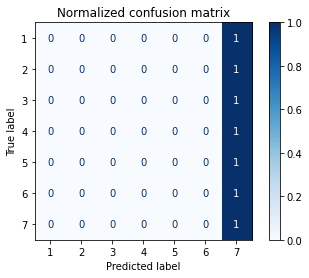

In [52]:
disp = plot_confusion_matrix(estimator=optimal_clf, 
                             X=X_valid, 
                             y_true=y_valid,
                             display_labels=cover_types,
                             cmap=plt.cm.Blues,
                             normalize='true'
                             )

disp.ax_.set_title("Normalized confusion matrix")

plt.show()